## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /home/sthenc/Work/CVND/data
!wget -P /home/sthenc/Work/CVND/data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /home/sthenc/Work/CVND/data/train-test-data.zip -d /home/sthenc/Work/CVND/data

mkdir: cannot create directory ‘/home/sthenc/Work/CVND/data’: File exists
--2018-12-08 22:31:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/home/sthenc/Work/CVND/data/train-test-data.zip.1’

train-test-data.zip   5%[>                   ]  18,15M  2,01MB/s    eta 2m 47s ^C
Archive:  /home/sthenc/Work/CVND/data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [32]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net
from models import Net2

net = Net()
#net = Net2()
print(net)

net.load_state_dict(torch.load('saved_models/keypoints_model_20180612.pt'))
#net.load_state_dict(torch.load('saved_models/keypoints_model_20180912.pt'))
#net.load_state_dict(torch.load('saved_models/keypoints_model_20180912_2_different_params.pt'))

#net.load_state_dict(torch.load('saved_models/keypoints_model2_20180912_2_different_params.pt'))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=307328, out_features=680, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=680, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

#data_transform2 = transforms.Compose([Rescale(250), RandomCrop(224), ToTensor()])

data_transform2 = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

#img = {'image': np.array([[1,2,3],[3,4,5],[6,7,8]]), 'keypoints': [[45, 50] for i in range(0, 68)]}

#data_transform(img)

# testing that you've defined a transform
assert(data_transform2 is not None), 'Define a data_transform'

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/home/sthenc/Work/CVND/data/training_frames_keypoints.csv',
                                             root_dir='/home/sthenc/Work/CVND/data/training/',
                                             transform=data_transform2)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    #print(i, sample['keypoints'].size)
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=6)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/home/sthenc/Work/CVND/data/test_frames_keypoints.csv',
                                             root_dir='/home/sthenc/Work/CVND/data/test/',
                                             transform=data_transform2)



In [7]:
# load test data in batches

# used this for first 20 epochs
#batch_size = 10

#test_loader = DataLoader(test_dataset, 
#                          batch_size=batch_size,
#                          shuffle=True, 
#                          num_workers=4)

batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=6) # home server has 12 cores


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [28]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# had problems with this step https://discuss.pytorch.org/t/expected-stride-to-be-a-single-integer-value-or-a-list/17612/4


# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [26]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

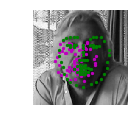

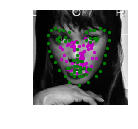

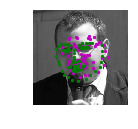

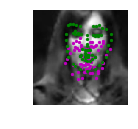

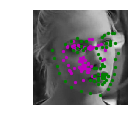

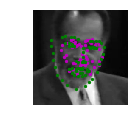

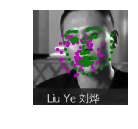

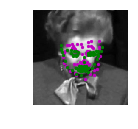

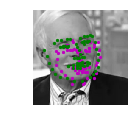

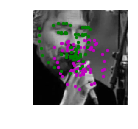

In [33]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=3):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print("loop")
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % batch_size == (batch_size-1):    # print `every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/batch_size))
                running_loss = 0.0

    print('Finished Training')


In [14]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

print("train for #epochs: " + str(n_epochs))
# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
#with active_session():
#    train_net(n_epochs)
    
train_net(n_epochs)
    
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model2_20180912_3_different_params.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

train for #epochs: 50
Epoch: 1, Batch: 10, Avg. Loss: 0.06894999742507935
Epoch: 1, Batch: 20, Avg. Loss: 0.07323442101478576
Epoch: 1, Batch: 30, Avg. Loss: 0.09380854219198227
Epoch: 1, Batch: 40, Avg. Loss: 0.07122355252504349
Epoch: 1, Batch: 50, Avg. Loss: 0.07929289638996125
Epoch: 1, Batch: 60, Avg. Loss: 0.06880542114377022
Epoch: 1, Batch: 70, Avg. Loss: 0.07245503664016724
Epoch: 1, Batch: 80, Avg. Loss: 0.07233156748116017
Epoch: 1, Batch: 90, Avg. Loss: 0.08156847208738327
Epoch: 1, Batch: 100, Avg. Loss: 0.06234067343175411
Epoch: 1, Batch: 110, Avg. Loss: 0.062482734024524686
Epoch: 1, Batch: 120, Avg. Loss: 0.07221550978720188
Epoch: 1, Batch: 130, Avg. Loss: 0.08134737946093082
Epoch: 1, Batch: 140, Avg. Loss: 0.06900062449276448
Epoch: 1, Batch: 150, Avg. Loss: 0.07607184462249279
Epoch: 1, Batch: 160, Avg. Loss: 0.05992592982947827
Epoch: 1, Batch: 170, Avg. Loss: 0.08097977042198182
Epoch: 1, Batch: 180, Avg. Loss: 0.07096254266798496
Epoch: 1, Batch: 190, Avg. Loss:

Epoch: 5, Batch: 210, Avg. Loss: 0.057046178728342056
Epoch: 5, Batch: 220, Avg. Loss: 0.07721447870135308
Epoch: 5, Batch: 230, Avg. Loss: 0.06795790530741215
Epoch: 5, Batch: 240, Avg. Loss: 0.07368333600461482
Epoch: 5, Batch: 250, Avg. Loss: 0.07243865616619587
Epoch: 5, Batch: 260, Avg. Loss: 0.08817760236561298
Epoch: 5, Batch: 270, Avg. Loss: 0.06485944055020809
Epoch: 5, Batch: 280, Avg. Loss: 0.06337433345615864
Epoch: 5, Batch: 290, Avg. Loss: 0.0626155637204647
Epoch: 5, Batch: 300, Avg. Loss: 0.060105353221297265
Epoch: 5, Batch: 310, Avg. Loss: 0.08400969244539738
Epoch: 5, Batch: 320, Avg. Loss: 0.06507404558360577
Epoch: 5, Batch: 330, Avg. Loss: 0.0754738762974739
Epoch: 5, Batch: 340, Avg. Loss: 0.07686958909034729
Epoch: 6, Batch: 10, Avg. Loss: 0.06716843321919441
Epoch: 6, Batch: 20, Avg. Loss: 0.07271121107041836
Epoch: 6, Batch: 30, Avg. Loss: 0.07622139155864716
Epoch: 6, Batch: 40, Avg. Loss: 0.08263129033148289
Epoch: 6, Batch: 50, Avg. Loss: 0.0718243677169084

Epoch: 10, Batch: 70, Avg. Loss: 0.07411826029419899
Epoch: 10, Batch: 80, Avg. Loss: 0.07126524485647678
Epoch: 10, Batch: 90, Avg. Loss: 0.06974930055439472
Epoch: 10, Batch: 100, Avg. Loss: 0.07703551612794399
Epoch: 10, Batch: 110, Avg. Loss: 0.06672030240297318
Epoch: 10, Batch: 120, Avg. Loss: 0.06535317450761795
Epoch: 10, Batch: 130, Avg. Loss: 0.06154293082654476
Epoch: 10, Batch: 140, Avg. Loss: 0.06741863377392292
Epoch: 10, Batch: 150, Avg. Loss: 0.07414952218532563
Epoch: 10, Batch: 160, Avg. Loss: 0.06737706139683723
Epoch: 10, Batch: 170, Avg. Loss: 0.06370475552976132
Epoch: 10, Batch: 180, Avg. Loss: 0.09333250224590302
Epoch: 10, Batch: 190, Avg. Loss: 0.07601169161498547
Epoch: 10, Batch: 200, Avg. Loss: 0.0626978375017643
Epoch: 10, Batch: 210, Avg. Loss: 0.05883793402463198
Epoch: 10, Batch: 220, Avg. Loss: 0.06308654807507992
Epoch: 10, Batch: 230, Avg. Loss: 0.05846594590693712
Epoch: 10, Batch: 240, Avg. Loss: 0.0888239737600088
Epoch: 10, Batch: 250, Avg. Loss:

Epoch: 14, Batch: 240, Avg. Loss: 0.0692157618701458
Epoch: 14, Batch: 250, Avg. Loss: 0.07261240892112256
Epoch: 14, Batch: 260, Avg. Loss: 0.05001392476260662
Epoch: 14, Batch: 270, Avg. Loss: 0.06403623409569263
Epoch: 14, Batch: 280, Avg. Loss: 0.06121071539819241
Epoch: 14, Batch: 290, Avg. Loss: 0.0616811003535986
Epoch: 14, Batch: 300, Avg. Loss: 0.07003636360168457
Epoch: 14, Batch: 310, Avg. Loss: 0.06605247780680656
Epoch: 14, Batch: 320, Avg. Loss: 0.08003305979073047
Epoch: 14, Batch: 330, Avg. Loss: 0.053836524672806266
Epoch: 14, Batch: 340, Avg. Loss: 0.07369938902556897
Epoch: 15, Batch: 10, Avg. Loss: 0.06391745321452617
Epoch: 15, Batch: 20, Avg. Loss: 0.08003749139606953
Epoch: 15, Batch: 30, Avg. Loss: 0.06109577137976885
Epoch: 15, Batch: 40, Avg. Loss: 0.07782537303864956
Epoch: 15, Batch: 50, Avg. Loss: 0.0823716577142477
Epoch: 15, Batch: 60, Avg. Loss: 0.07343628779053687
Epoch: 15, Batch: 70, Avg. Loss: 0.06096791848540306
Epoch: 15, Batch: 80, Avg. Loss: 0.08

Epoch: 19, Batch: 70, Avg. Loss: 0.07385111190378665
Epoch: 19, Batch: 80, Avg. Loss: 0.06814376115798951
Epoch: 19, Batch: 90, Avg. Loss: 0.07072362825274467
Epoch: 19, Batch: 100, Avg. Loss: 0.07643047049641609
Epoch: 19, Batch: 110, Avg. Loss: 0.06490727551281453
Epoch: 19, Batch: 120, Avg. Loss: 0.05035434812307358
Epoch: 19, Batch: 130, Avg. Loss: 0.06321819685399532
Epoch: 19, Batch: 140, Avg. Loss: 0.054150105267763135
Epoch: 19, Batch: 150, Avg. Loss: 0.050676123984158036
Epoch: 19, Batch: 160, Avg. Loss: 0.049971061013638976
Epoch: 19, Batch: 170, Avg. Loss: 0.05779312569648028
Epoch: 19, Batch: 180, Avg. Loss: 0.054611493088305
Epoch: 19, Batch: 190, Avg. Loss: 0.045471960306167604
Epoch: 19, Batch: 200, Avg. Loss: 0.06715660206973553
Epoch: 19, Batch: 210, Avg. Loss: 0.07067331559956073
Epoch: 19, Batch: 220, Avg. Loss: 0.05103760529309511
Epoch: 19, Batch: 230, Avg. Loss: 0.07410214487463236
Epoch: 19, Batch: 240, Avg. Loss: 0.0701610840857029
Epoch: 19, Batch: 250, Avg. Lo

Epoch: 23, Batch: 240, Avg. Loss: 0.045841097459197046
Epoch: 23, Batch: 250, Avg. Loss: 0.05336989089846611
Epoch: 23, Batch: 260, Avg. Loss: 0.06313764285296201
Epoch: 23, Batch: 270, Avg. Loss: 0.060973620414733885
Epoch: 23, Batch: 280, Avg. Loss: 0.05939819235354662
Epoch: 23, Batch: 290, Avg. Loss: 0.05044347979128361
Epoch: 23, Batch: 300, Avg. Loss: 0.063820805773139
Epoch: 23, Batch: 310, Avg. Loss: 0.07922107353806496
Epoch: 23, Batch: 320, Avg. Loss: 0.07267309539020061
Epoch: 23, Batch: 330, Avg. Loss: 0.04851560369133949
Epoch: 23, Batch: 340, Avg. Loss: 0.061384421214461325
Epoch: 24, Batch: 10, Avg. Loss: 0.07155454754829407
Epoch: 24, Batch: 20, Avg. Loss: 0.06454649344086646
Epoch: 24, Batch: 30, Avg. Loss: 0.0939459666609764
Epoch: 24, Batch: 40, Avg. Loss: 0.07129457779228687
Epoch: 24, Batch: 50, Avg. Loss: 0.08885314557701349
Epoch: 24, Batch: 60, Avg. Loss: 0.0759164709597826
Epoch: 24, Batch: 70, Avg. Loss: 0.058713707700371744
Epoch: 24, Batch: 80, Avg. Loss: 0.

Epoch: 28, Batch: 70, Avg. Loss: 0.06702642738819123
Epoch: 28, Batch: 80, Avg. Loss: 0.08187685031443834
Epoch: 28, Batch: 90, Avg. Loss: 0.055811180546879766
Epoch: 28, Batch: 100, Avg. Loss: 0.057678810134530065
Epoch: 28, Batch: 110, Avg. Loss: 0.059693888574838636
Epoch: 28, Batch: 120, Avg. Loss: 0.0796455729752779
Epoch: 28, Batch: 130, Avg. Loss: 0.04751441646367312
Epoch: 28, Batch: 140, Avg. Loss: 0.06366710513830184
Epoch: 28, Batch: 150, Avg. Loss: 0.05381109230220318
Epoch: 28, Batch: 160, Avg. Loss: 0.0948290441185236
Epoch: 28, Batch: 170, Avg. Loss: 0.07332896105945111
Epoch: 28, Batch: 180, Avg. Loss: 0.05960614681243896
Epoch: 28, Batch: 190, Avg. Loss: 0.057950491830706594
Epoch: 28, Batch: 200, Avg. Loss: 0.0583359956741333
Epoch: 28, Batch: 210, Avg. Loss: 0.05230819415301084
Epoch: 28, Batch: 220, Avg. Loss: 0.06164718195796013
Epoch: 28, Batch: 230, Avg. Loss: 0.06084481105208397
Epoch: 28, Batch: 240, Avg. Loss: 0.06102880015969277
Epoch: 28, Batch: 250, Avg. Lo

Epoch: 32, Batch: 240, Avg. Loss: 0.05571519508957863
Epoch: 32, Batch: 250, Avg. Loss: 0.05459168683737516
Epoch: 32, Batch: 260, Avg. Loss: 0.06758659519255161
Epoch: 32, Batch: 270, Avg. Loss: 0.06353229470551014
Epoch: 32, Batch: 280, Avg. Loss: 0.06516908667981625
Epoch: 32, Batch: 290, Avg. Loss: 0.07184225544333459
Epoch: 32, Batch: 300, Avg. Loss: 0.057502776756882666
Epoch: 32, Batch: 310, Avg. Loss: 0.05235299300402403
Epoch: 32, Batch: 320, Avg. Loss: 0.059313816204667094
Epoch: 32, Batch: 330, Avg. Loss: 0.06638056673109531
Epoch: 32, Batch: 340, Avg. Loss: 0.0630262777209282
Epoch: 33, Batch: 10, Avg. Loss: 0.06642481572926044
Epoch: 33, Batch: 20, Avg. Loss: 0.06945691630244255
Epoch: 33, Batch: 30, Avg. Loss: 0.0707959670573473
Epoch: 33, Batch: 40, Avg. Loss: 0.060841981694102286
Epoch: 33, Batch: 50, Avg. Loss: 0.06090654134750366
Epoch: 33, Batch: 60, Avg. Loss: 0.08833012953400612
Epoch: 33, Batch: 70, Avg. Loss: 0.06922471318393945
Epoch: 33, Batch: 80, Avg. Loss: 0

Epoch: 37, Batch: 70, Avg. Loss: 0.057572199031710625
Epoch: 37, Batch: 80, Avg. Loss: 0.06633401364088058
Epoch: 37, Batch: 90, Avg. Loss: 0.06220996715128422
Epoch: 37, Batch: 100, Avg. Loss: 0.06386389210820198
Epoch: 37, Batch: 110, Avg. Loss: 0.06528344675898552
Epoch: 37, Batch: 120, Avg. Loss: 0.054319914802908896
Epoch: 37, Batch: 130, Avg. Loss: 0.07214998882263898
Epoch: 37, Batch: 140, Avg. Loss: 0.045966916531324384
Epoch: 37, Batch: 150, Avg. Loss: 0.04532065466046333
Epoch: 37, Batch: 160, Avg. Loss: 0.06039872504770756
Epoch: 37, Batch: 170, Avg. Loss: 0.06546510905027389
Epoch: 37, Batch: 180, Avg. Loss: 0.04913375061005354
Epoch: 37, Batch: 190, Avg. Loss: 0.07275373674929142
Epoch: 37, Batch: 200, Avg. Loss: 0.06368191689252853
Epoch: 37, Batch: 210, Avg. Loss: 0.05167380608618259
Epoch: 37, Batch: 220, Avg. Loss: 0.04856507442891598
Epoch: 37, Batch: 230, Avg. Loss: 0.07407211437821389
Epoch: 37, Batch: 240, Avg. Loss: 0.06760075576603412
Epoch: 37, Batch: 250, Avg. 

Epoch: 41, Batch: 240, Avg. Loss: 0.050153177604079245
Epoch: 41, Batch: 250, Avg. Loss: 0.06229526363313198
Epoch: 41, Batch: 260, Avg. Loss: 0.052284613251686096
Epoch: 41, Batch: 270, Avg. Loss: 0.047742832079529764
Epoch: 41, Batch: 280, Avg. Loss: 0.044314489141106604
Epoch: 41, Batch: 290, Avg. Loss: 0.059609814547002316
Epoch: 41, Batch: 300, Avg. Loss: 0.05374929942190647
Epoch: 41, Batch: 310, Avg. Loss: 0.05758772250264883
Epoch: 41, Batch: 320, Avg. Loss: 0.06119413450360298
Epoch: 41, Batch: 330, Avg. Loss: 0.04891154672950506
Epoch: 41, Batch: 340, Avg. Loss: 0.047364048287272455
Epoch: 42, Batch: 10, Avg. Loss: 0.07592423595488071
Epoch: 42, Batch: 20, Avg. Loss: 0.0701446209102869
Epoch: 42, Batch: 30, Avg. Loss: 0.05561200194060802
Epoch: 42, Batch: 40, Avg. Loss: 0.060986483469605446
Epoch: 42, Batch: 50, Avg. Loss: 0.06939420700073243
Epoch: 42, Batch: 60, Avg. Loss: 0.0764501415193081
Epoch: 42, Batch: 70, Avg. Loss: 0.05817857105284929
Epoch: 42, Batch: 80, Avg. Los

Epoch: 46, Batch: 70, Avg. Loss: 0.07446784637868405
Epoch: 46, Batch: 80, Avg. Loss: 0.061632240563631056
Epoch: 46, Batch: 90, Avg. Loss: 0.052049263194203374
Epoch: 46, Batch: 100, Avg. Loss: 0.058544181287288666
Epoch: 46, Batch: 110, Avg. Loss: 0.04578026458621025
Epoch: 46, Batch: 120, Avg. Loss: 0.06260446459054947
Epoch: 46, Batch: 130, Avg. Loss: 0.05079002883285284
Epoch: 46, Batch: 140, Avg. Loss: 0.05479039419442415
Epoch: 46, Batch: 150, Avg. Loss: 0.04913979358971119
Epoch: 46, Batch: 160, Avg. Loss: 0.045729007571935654
Epoch: 46, Batch: 170, Avg. Loss: 0.043043265119194984
Epoch: 46, Batch: 180, Avg. Loss: 0.05761898458003998
Epoch: 46, Batch: 190, Avg. Loss: 0.05811568107455969
Epoch: 46, Batch: 200, Avg. Loss: 0.055142573267221454
Epoch: 46, Batch: 210, Avg. Loss: 0.05398077648133039
Epoch: 46, Batch: 220, Avg. Loss: 0.07535301893949509
Epoch: 46, Batch: 230, Avg. Loss: 0.06357503701001406
Epoch: 46, Batch: 240, Avg. Loss: 0.05277916584163904
Epoch: 46, Batch: 250, Av

Epoch: 50, Batch: 230, Avg. Loss: 0.05152097847312689
Epoch: 50, Batch: 240, Avg. Loss: 0.045983906090259555
Epoch: 50, Batch: 250, Avg. Loss: 0.04892295766621828
Epoch: 50, Batch: 260, Avg. Loss: 0.058626831881701945
Epoch: 50, Batch: 270, Avg. Loss: 0.0494789469987154
Epoch: 50, Batch: 280, Avg. Loss: 0.04914097338914871
Epoch: 50, Batch: 290, Avg. Loss: 0.05279203299432993
Epoch: 50, Batch: 300, Avg. Loss: 0.042751367390155795
Epoch: 50, Batch: 310, Avg. Loss: 0.06820347439497709
Epoch: 50, Batch: 320, Avg. Loss: 0.0543142769485712
Epoch: 50, Batch: 330, Avg. Loss: 0.05156832989305258
Epoch: 50, Batch: 340, Avg. Loss: 0.04698893986642361
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [33]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([3, 1, 224, 224])
torch.Size([3, 68, 2])
torch.Size([3, 68, 2])


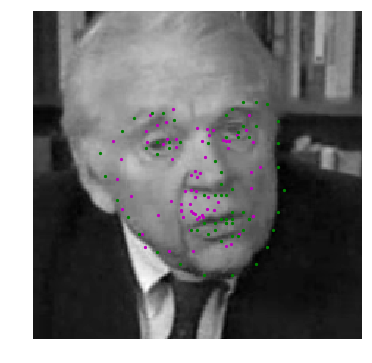

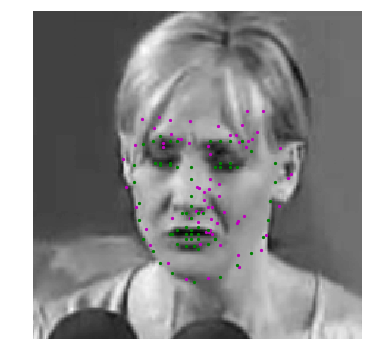

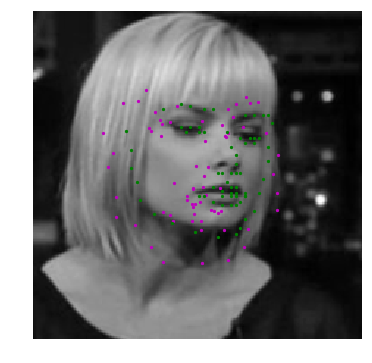

In [34]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!